# Analogous Years
The Analogous Years application enables users to compare events from a set period of time, 
to those of the same date range in other years. The application will compute ranks of similarity between the specified period, and the same period from previous or future years.

## Table of Contents <a class="anchor" id="link-0.0"></a>
0. [Gro API Client](#link-0)
    - [Import Gro Client And Analogous Years' Functions](#link-0.1)
    - [Set Up Environment To Access Gro API](#link-0.2)
- [Input](#link-1)
    - [Gro Data Series](#link-1.1)
    - [Time Period](#link-1.2)
- [Output](#link-2)
- [Appendix](#link-3)
    - [Methods Of Rank Calculation](#link-3.1)
    - [Additional Options](#link-3.2)
- [Report](#link-4)
    - [Correlation Matrix](#link-4.1)
    - [Scatterplots Between Ranks](./get_started_with_analogous_years.ipynb/#link-4.2)


## 0. Gro API Client<a class="anchor" id="link-0"></a>

### 0.1 Import Gro Client And Analogous Years' Functions<a class="anchor" id="link-0.1"></a>
To get started with `Analogous Years`, users have to install `Gro API Client`
as detailed [here](https://developers.gro-intelligence.com/installation.html). Following that users can run the following cell to import Gro client and some of the necessary libraries from the `analogous_years` package.

In [1]:
import os
from api.client.gro_client import GroClient
from api.client.samples.analogous_years import run_analogous_years
from api.client.samples.analogous_years.lib import final_ranks_computation, get_transform_data
import logging
import pandas as pd
pd.options.mode.chained_assignment = None

/Users/saikatdas/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### 0.2 Set Up Environment To Access Gro API<a class="anchor" id="link-0.2"></a>
Assuming that users have saved the Gro API access token as an environment variable named `GROAPI_TOKEN` (and have imported `os` in the previous step), users may run the following cell to define `client` for interaction with Gro API

[Top](#link-0.0)

In [2]:
API_HOST = 'api.gro-intelligence.com'
ACCESS_TOKEN = os.environ['GROAPI_TOKEN']
client = GroClient(API_HOST, ACCESS_TOKEN)
logging.disable(level=logging.ERROR)

## 1. Input<a class="anchor" id="link-1"></a>
Multiple different inputs can be used in determining the ranks (refer to the appendix), but to compute these ranks, a user must provide:
### 1.1 Gro Data Series<a class="anchor" id="link-1.1"></a>
Single or multiple Gro Data Series defined by `metric_id`, `item_id`, `source_id`, `frequency_id` for a particular region given by a `region_id`.
### 1.2 Time Period<a class="anchor" id="link-1.2"></a>
A time period determined by an `initial_date` and a `final_date`. The two dates must be within 1 year of each other and in the `YYYY-MM-DD` format.
### Example
As an example, if the user wants to know which period of time is most similar to the time period between 1<sup>st</sup> January 2019 and 31<sup>st</sup> October 2019 in the [US Corn Belt States (region_id=100000100)](https://app.gro-intelligence.com/dictionary/regions/100000100) with respect to the
following Gro Data Series -
1. Rainfall, TRMM ([metric_id=2100031](https://app.gro-intelligence.com/dictionary/metrics/2100031), [item_id=2039](https://app.gro-intelligence.com/dictionary/items/2039), [source_id=35](https://app.gro-intelligence.com/dictionary/sources/35), frequency_id=1)
2. Land Temperature, MODIS ([metric_id=2540047](https://app.gro-intelligence.com/dictionary/metrics/2540047), [item_id=3457](https://app.gro-intelligence.com/dictionary/items/3457), [source_id=26](https://app.gro-intelligence.com/dictionary/sources/26), frequency_id=1)
3. Soil moisture, SMOS ([metric_id=15531082](https://app.gro-intelligence.com/dictionary/items/15531082), [item_id=7382](https://app.gro-intelligence.com/dictionary/items/7382), [source_id=43](https://app.gro-intelligence.com/dictionary/sources/43), frequency_id=1)

Note: 1. `frequency_id: 1` gives us daily values. In absence of daily values, 
the application up-samples to daily frequency(ies).
2. A convenient way to incorporate these is to copy the dictionaries associated to the data series mentioned above from [Gro webapp display](https://app.gro-intelligence.com/displays/za9MlQYRM) by exporting the api client code snippets of the display. The copied data series will be stored in `data_series_list` as outlined below.

[Top](./get_started_with_analogous_years.ipynb/#link-0.0)

In [3]:
# Rainfall (modeled) - Precipitation Quantity - US Corn Belt States (NASA TRMM 3B42RT)
data_series_1 = {'metric_id': 2100031, 
                 'item_id': 2039, 
                 'region_id': 100000100, 
                 'partner_region_id': 0, 
                 'source_id': 35, 
                 'frequency_id': 1, 
                 'unit_id': 2}
# Land temperature (daytime, modeled) - Temperature - US Corn Belt States (NASA MODIS MOD11 LST)
data_series_2 = {'metric_id': 2540047, 
                 'item_id': 3457, 
                 'region_id': 100000100, 
                 'partner_region_id': 0, 
                 'source_id': 26, 
                 'frequency_id': 1,
                 'unit_id': 36}

# Soil moisture - Availability in soil (volume/volume) - US Corn Belt States (ESA SMOS CLF33D)
data_series_3 = {'metric_id': 15531082, 
            'item_id': 7382, 
            'region_id': 100000100, 
            'partner_region_id': 0, 
            'source_id': 43, 
            'frequency_id': 1}


data_series_list = [data_series_1, data_series_2, data_series_3]


initial_date = '2019-01-01'
final_date = '2019-10-31'

## 2. Output<a class="anchor" id="link-2"></a>
The output will be a pandas dataframe containg the ranks computed by ensembling several distance calculation method.

[Top](#link-0.0)

In [4]:
result = final_ranks_computation.analogous_years(
    client, data_series_list, initial_date, final_date)
result

Feature Extraction: 100%|██████████| 9/9 [00:01<00:00,  3.57it/s]


,composite_rank
period,
2011-01-01 to 2011-10-31,5
2012-01-01 to 2012-10-31,9
2013-01-01 to 2013-10-31,3
2014-01-01 to 2014-10-31,6
2015-01-01 to 2015-10-31,7
2016-01-01 to 2016-10-31,2
2017-01-01 to 2017-10-31,8
2018-01-01 to 2018-10-31,4
2019-01-01 to 2019-10-31,1


## 3. Appendix<a class="anchor" id="link-3"></a>
### 3.1 Methods Of Rank Calculation<a class="anchor" id="link-3.1"></a>
The analogy score between two different time periods can be measured in multiple ways. 
Here, the program can calculate ranks based on 2 primary approaches - 
1. Ranks based on differences between extracted features: 
    1. Distance between cumulative sums. 
    2. Distance between more features extracted from time series. 
    
    Note: For the purpose of this package we have used `tsfresh` package to 
    extract data from time series. 
2. Point wise differences: 
    1. Euclidean distance between stacked time periods. 
    2. Dynamic Time Warping distance between stacked time periods.
    
Finally, the program returns a composite rank by default based on the default 
(`cumulative`, `euclidean`, `ts-features`) methods or user specified methods.

[Top](#link-0.0)

### 3.2 Additional Options<a class="anchor" id="link-3.2"></a>
1. Methods: Users have an option to choose from the following methods for distance 
computation `cumulative`, `euclidean`, `ts-features`, `dtw`. The default methods for rank 
generation are `cumulative`, `euclidean`, `ts-features`. `dtw` method is intentionally 
left out of the default setting as it is computationally expensive to run dynamic time warping 
algorithm on one `item-metric` tuple and in most situations `dtw` ranks are highly 
correlated with the `euclidean` ranks.

2. All Ranks: Users have an option to output multiple individual ranks or an ensemble rank
based on their methods list. By default only the ensemble rank will be generated.

3. Multivariate El Niño Southern Oscillation (ENSO) index can also be included in the 
rank computation, along with the weight that the user wants to give for the ENSO index. 
The weight of ENSO index is set to 1 by default.

4. Start Date: Users have an option to exclude time periods before a specified date. By 
default the earliest date from which data is available for all entities will be used to 
compute ranks.

[Top](#link-0.0)

In [5]:
additional_options_result = final_ranks_computation.analogous_years(
    client, data_series_list, initial_date, final_date, 
    methods_list=['cumulative', 'euclidean', 'ts-features', 'dtw'], 
    all_ranks=True, weights=[0.2, 0.3, 0.4], enso=True,
    enso_weight=0.1, provided_start_date='2015-01-01')
additional_options_result

Feature Extraction: 100%|██████████| 5/5 [00:00<00:00,  2.99it/s]


,cumulative_rank,euclidean_rank,dtw_rank,ts-features_rank,composite_rank
period,,,,,
2015-01-01 to 2015-10-31,4,3,4,3,4
2016-01-01 to 2016-10-31,3,2,2,2,3
2017-01-01 to 2017-10-31,5,5,5,5,5
2018-01-01 to 2018-10-31,2,4,3,4,2
2019-01-01 to 2019-10-31,1,1,1,1,1


## 4. Report<a class="anchor" id="link-4"></a>

1. Location: Files containing the ranks (and possibly reports) can be saved in a subdirectory under the present working directory (unless a different location is stated). To save the result as a file named `ranks.csv` in the directory of user's choice the user have to run the following block of code.
```python
output_dir = <output directory>
folder_name = final_ranks_computation.get_file_name(
    client, 
    data_series_list, 
    initial_date=initial_date, 
    final_date=final_date
)
final_ranks_computation.save_to_csv(
    client, 
    additional_options_result,
    folder_name,
    file_name='ranks.csv',
    output_dir=output_dir
)
```
2. Report: A correlation matrix as a csv file, together with a png file of pairwise scatter 
plots between ranks, for selected methods, can be generated and saved in the same folder where the ranks in csv format is saved whenever users opt to generate multiple ranks.
```python
correlation_matrix = final_ranks_computation.generate_correlation_matrix(
    additional_options_result
)
final_ranks_computation.save_to_csv(
    client, 
    correlation_matrix,
    folder_name,
    file_name='correlation_matrix.csv',
    output_dir=output_dir
)
final_ranks_computation.generate_correlation_scatterplots(
    client, 
    additional_options_result, 
    folder_name,
    output_dir=output_dir
)
```


### 4.1 Correlation Matrix<a class="anchor" id="link-4.1"></a>
Since, we are using a notebook we can generate the report independently. In this section we have computed the `spearman's rank correlation` between the ranks to see if there is any anomaly between the ranks. From our past observations we have found that the `dtw_rank` is highly correlated with `euclidean_rank`. Hence, for computational efficiency we advise the user to avoid `dtw` in the `list_of_methods`.

[Top](./get_started_with_analogous_years.ipynb/#link-0.0)

In [6]:
correlation_matrix = additional_options_result.corr(method='spearman')
correlation_matrix

,cumulative_rank,euclidean_rank,dtw_rank,ts-features_rank,composite_rank
cumulative_rank,1.0,0.7,0.9,0.7,1.0
euclidean_rank,0.7,1.0,0.9,1.0,0.7
dtw_rank,0.9,0.9,1.0,0.9,0.9
ts-features_rank,0.7,1.0,0.9,1.0,0.7
composite_rank,1.0,0.7,0.9,0.7,1.0


### 4.2 Scatterplots Between Ranks<a class="anchor" id="link-4.2"></a>
We have used `seaborn` for graphing. The user is free to use other libraries such as `plotly`/ `matplotlib` for graphing. For `plotly` please _uncomment_ the last seven lines of code and _comment out_ the first six lines of code below.

[Top](#link-0.0)

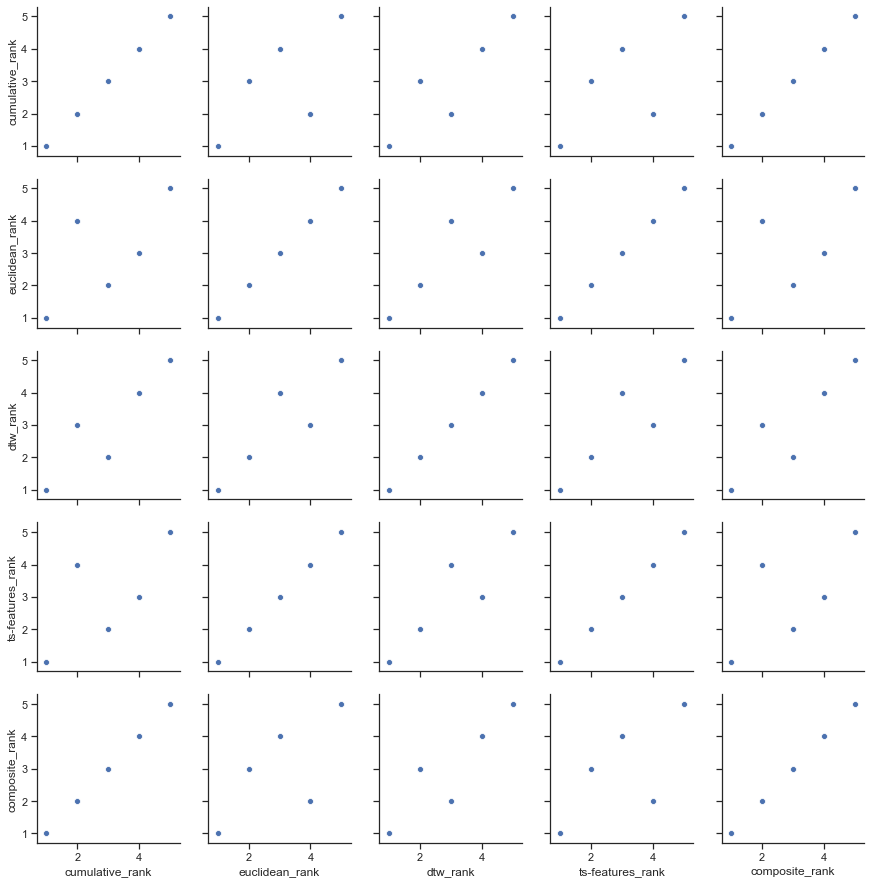

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns_plot = sns.pairplot(additional_options_result, diag_kind=None)
plt.show()

# import plotly.figure_factory as ff
# from plotly.offline import iplot, init_notebook_mode
# import cufflinks
# cufflinks.go_offline(connected = True)
# init_notebook_mode(connected = True)
# figure = ff.create_scatterplotmatrix(additional_options_result, height=1000, width=1000)
# figure.show()